# PCA и kNN (метод главных компонент и k ближайших соседей)

Дибель Софья Васильевна НПМбд-01-19а

In [332]:
import numpy as np

Скачали базу данных digits при помощи функции load_digits из пакета sklearn.datasets. Получили массивы картинок в виде массива X, а также ответов labels.

In [333]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits['data']
labels = digits['target']

При помощи функции matplotlib.pyplot.imshow нарисовали несколько примеров картинок из X. Чтобы картинки шли в виде массива, а не друг под другом, использовали функцию subplots.

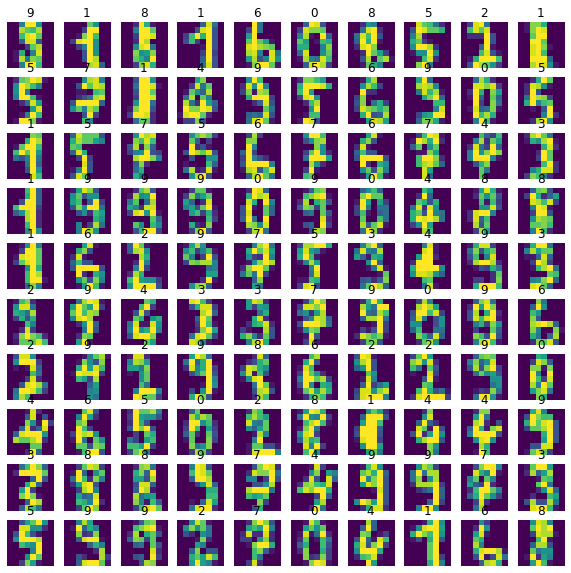

In [334]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        k = np.random.randint(0, 1797)
        axis[i, j].imshow(X[k,:].reshape((8, 8)))  # Display data as an image, i.e., on a 2D regular raster.
        axis[i, j].set_title(labels[k])
        axis[i, j].axis('off')

## PCA (метод главных компонент)

Метод позволяет выделять наиболее существенную информацию из данных с помощью линейных преобразований.

Метод главных компонент состоит из следующих 4-х шагов:
1. Центрирование данных: $X_c$ = $X$ - $\overline X$, где $\overline X$ - среднее для каждого параметра.
2. Вычисление матрицы ковариации: $C$ = $X_c^TX_c$.
3. Вычисление собственных векторов $F$ и значений $\lambda$ матрицы ковариации $C$. 
4. Преобразование данных в координаты в базисе главных компонент $Y=X_cF$.


In [336]:
class PCA():
    def __init__(self, n_components=None):
        """
        n_components - количество компонент, которые мы хотим оставить
        """
        self.n_components = n_components
    def fit(self, X):
        """
        Возвращает центрированные данные, с.в. и с.з. матрицы ковариации в убывающем порядке
        """
        X -= X.mean(axis=0)  # Центрируем данные
        C = X.T.dot(X)  # Матрица ковариации
        eig_values, F = np.linalg.eigh(C)  # с.з. и с.в.
        eig_values = eig_values[::-1]
        F = F[:, ::-1]
        return X, F, eig_values
    def transform(self, X, F): 
        """
        Перемножает две матрицы
        """
        X_ = X.dot(F)
        return X_
    def fit_transform(self, X): 
        """
        Возвращает данные, преобразованные в координаты базиса гланых компонент, оставив первые n_components штук
        """
        X = self.fit(X)[0]
        F = self.fit(X)[1]
        X = self.transform(X, F)[:, :self.n_components]  # fit_transform(X).shape = (1797, 64)
        return X

График собственных значений матрицы ковариации, упорядоченных по убыванию:

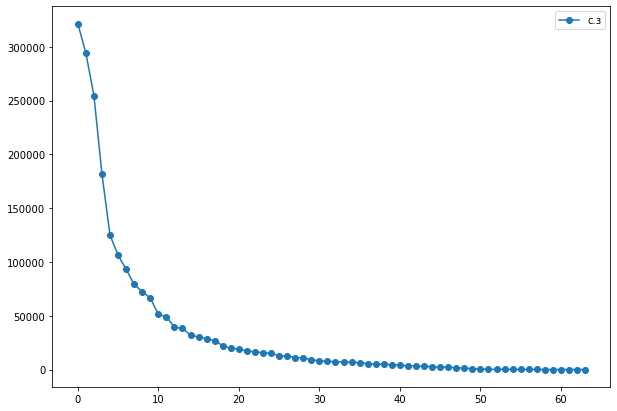

In [345]:
pca = PCA()
eig = pca.fit(X)[2]
plt.figure(figsize=(10, 7))
plt.plot(eig, 'o-', label='с.з')
plt.legend()

График отношения кумулятивной суммы собственных значений матрицы ковариации к их полной сумме:

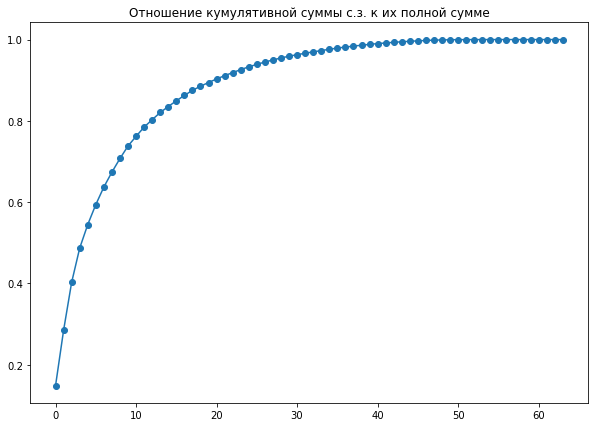

In [338]:
eig_sum = np.sum(eig)
eig_cumsum = np.cumsum(eig)
f = eig_cumsum / eig_sum
plt.figure(figsize=(10, 7))
plt.title('Отношение кумулятивной суммы с.з. к их полной сумме')
plt.plot(f, 'o-')

+ дисперсия в квадрате равна собственному числу
+ первые 15 главных компонент покрывают ~85% дисперсии

Изобразили на графике точки датасета в первых двух координатах главных компонент. Разным цифрам соответствуют разные цвета.

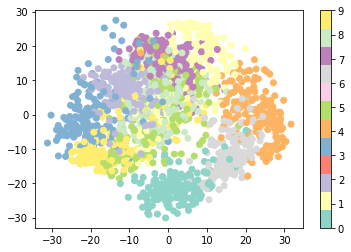

In [339]:
X_ = pca.fit_transform(X)
plt.scatter(X_[:, 0], X_[:, 1], c=labels, cmap='Set3')  # A scatter plot of *y* vs. *x* with varying marker size and/or color.
plt.colorbar()

Видим, что разные цифры сгруппировались, хоть и неидеально, но группы можно отличить друг от друга.

## kNN (метод k ближайших соседей)

Алгоритм k-ближайших соседей (k-nearest neighbours (kNN)) является одним из простейших метрических алгоритмов для решения задач классификации объектов.

+ Суть алгоритма: 
+ Пусть у нас есть некоторая обучающая выборка данных $X$ с известными классами принадлежности объектов $labels$. Предположим, есть некоторый объект $x_*$ с неизвестным классом, который мы хотели бы предсказать.
+ Для этого посчитаем расстояния от $x_*$ до каждого из объектов $X$ и найдём $k$ ближайших (т.е. с наименьшим расстоянием) из этого набора. Поскольку мы знаем, к какому классу принадлежат эти $k$ соседей, то мы можем предположить, что и наш объект $x_*$ будет принадлежать к тому классу, из которого наибольшее количество соседей.
+ Например, пусть $k = 7$ и среди этих семи ближайших соседей четыре соседа оказалось в классе $A$, один сосед оказался в классе $B$ и ещё два соседа оказалось в классе $C$, значит мы делаем предположение, что и наш объект $x_*$ принадлежит классу $A$.

In [341]:
# train - на чем проверяем
# test - что проверяем

class kNN():
    def __init__(self, n_neighbors=5):
        """
        n_neighbors - количество "соседей"
        """
        self.n_neighbors = n_neighbors
    def fit(self, X_train, labels_train):
        """
        Сохраняет переданные обучающие данные во внутренние переменные
        """
        self.X_train = X_train
        self.labels_train = labels_train
    def predict(self, X_test):
        """
        Вычисляет расстояния до всех точек из обучающей выборки
        Выбирает n_neighbors точек с наименьшими расстояниями
        Оставляет самого часто встречающего "соседа"
        """
        neighbors = []
        for x in X_test:
            r = np.sqrt(np.sum((x - self.X_train)**2, axis=1))  # расстояние от х из X до точек из X_train (массив расстояний длиной, равной кол-ву точек, до которых считаем расстояние)
            labels_sorted = [i for _, i in sorted(zip(r, self.labels_train))]  #  расстояния и ответ (цифры) в виде таплов - отсортирован по возрастанию расстояния, берем из него вторые значения - то есть ответы
            neighbors.append(labels_sorted[:self.n_neighbors])
        result = []
        for ar in neighbors:
            result.append(max(ar, key=ar.count))
        return result

Разбили данные X и labels на обучающую и тестовую выборку, используя функцию train_test_split из модуля sklearn.model_selection. Посчитали точность на тестовой выборке, используя функцию accuracy_score из модуля sklearn.metrics для компонент от 1 до 64 и соседей от 1 до 30.

In [343]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time

start = time.time()

for i in range(1, 65):
    print(f'размерность = {i}')
    pca = PCA(i)
    X_ = pca.fit_transform(X)
    for j in range(1, 31):
        X_train, X_test, labels_train, labels_test = train_test_split(X_, labels, test_size=0.33, random_state=42)
        knn = kNN(j) 
        knn.fit(X_train, labels_train)
        print(f'соседей: {j}, точность = {accuracy_score(knn.predict(X_test), labels_test)}')
print()

end = time.time()
print(f'Это заняло времени: {end-start} секунд')

размерность = 1
соседей: 1, точность = 0.26936026936026936
соседей: 2, точность = 0.26936026936026936
соседей: 3, точность = 0.26936026936026936
соседей: 4, точность = 0.2962962962962963
соседей: 5, точность = 0.30303030303030304
соседей: 6, точность = 0.3181818181818182
соседей: 7, точность = 0.30808080808080807
соседей: 8, точность = 0.32154882154882153
соседей: 9, точность = 0.32154882154882153
соседей: 10, точность = 0.3333333333333333
соседей: 11, точность = 0.3434343434343434
соседей: 12, точность = 0.3569023569023569
соседей: 13, точность = 0.35353535353535354
соседей: 14, точность = 0.35353535353535354
соседей: 15, точность = 0.36195286195286197
соседей: 16, точность = 0.3569023569023569
соседей: 17, точность = 0.3569023569023569
соседей: 18, точность = 0.3569023569023569
соседей: 19, точность = 0.3653198653198653
соседей: 20, точность = 0.35353535353535354
соседей: 21, точность = 0.3602693602693603
соседей: 22, точность = 0.3552188552188552
соседей: 23, точность = 0.3653198653

соседей: 11, точность = 0.9511784511784511
соседей: 12, точность = 0.9528619528619529
соседей: 13, точность = 0.9511784511784511
соседей: 14, точность = 0.9528619528619529
соседей: 15, точность = 0.9545454545454546
соседей: 16, точность = 0.9545454545454546
соседей: 17, точность = 0.9494949494949495
соседей: 18, точность = 0.9511784511784511
соседей: 19, точность = 0.9461279461279462
соседей: 20, точность = 0.9461279461279462
соседей: 21, точность = 0.9461279461279462
соседей: 22, точность = 0.9461279461279462
соседей: 23, точность = 0.9461279461279462
соседей: 24, точность = 0.9461279461279462
соседей: 25, точность = 0.9393939393939394
соседей: 26, точность = 0.9427609427609428
соседей: 27, точность = 0.9343434343434344
соседей: 28, точность = 0.936026936026936
соседей: 29, точность = 0.9343434343434344
соседей: 30, точность = 0.9326599326599326
размерность = 8
соседей: 1, точность = 0.9612794612794613
соседей: 2, точность = 0.9612794612794613
соседей: 3, точность = 0.9646464646464646

соседей: 21, точность = 0.9663299663299664
соседей: 22, точность = 0.968013468013468
соседей: 23, точность = 0.9646464646464646
соседей: 24, точность = 0.9646464646464646
соседей: 25, точность = 0.9595959595959596
соседей: 26, точность = 0.9612794612794613
соседей: 27, точность = 0.9595959595959596
соседей: 28, точность = 0.9595959595959596
соседей: 29, точность = 0.9562289562289562
соседей: 30, точность = 0.9579124579124579
размерность = 14
соседей: 1, точность = 0.9848484848484849
соседей: 2, точность = 0.9848484848484849
соседей: 3, точность = 0.9848484848484849
соседей: 4, точность = 0.9865319865319865
соседей: 5, точность = 0.9865319865319865
соседей: 6, точность = 0.9865319865319865
соседей: 7, точность = 0.9865319865319865
соседей: 8, точность = 0.98989898989899
соседей: 9, точность = 0.9865319865319865
соседей: 10, точность = 0.98989898989899
соседей: 11, точность = 0.9797979797979798
соседей: 12, точность = 0.9797979797979798
соседей: 13, точность = 0.9730639730639731
соседей:

соседей: 1, точность = 0.9848484848484849
соседей: 2, точность = 0.9848484848484849
соседей: 3, точность = 0.98989898989899
соседей: 4, точность = 0.98989898989899
соседей: 5, точность = 0.9915824915824916
соседей: 6, точность = 0.98989898989899
соседей: 7, точность = 0.98989898989899
соседей: 8, точность = 0.98989898989899
соседей: 9, точность = 0.98989898989899
соседей: 10, точность = 0.98989898989899
соседей: 11, точность = 0.9882154882154882
соседей: 12, точность = 0.9865319865319865
соседей: 13, точность = 0.9814814814814815
соседей: 14, точность = 0.9831649831649831
соседей: 15, точность = 0.9747474747474747
соседей: 16, точность = 0.9781144781144782
соседей: 17, точность = 0.9764309764309764
соседей: 18, точность = 0.9730639730639731
соседей: 19, точность = 0.9696969696969697
соседей: 20, точность = 0.9713804713804713
соседей: 21, точность = 0.9713804713804713
соседей: 22, точность = 0.9696969696969697
соседей: 23, точность = 0.968013468013468
соседей: 24, точность = 0.964646464

соседей: 13, точность = 0.9797979797979798
соседей: 14, точность = 0.9797979797979798
соседей: 15, точность = 0.9764309764309764
соседей: 16, точность = 0.9764309764309764
соседей: 17, точность = 0.9747474747474747
соседей: 18, точность = 0.9764309764309764
соседей: 19, точность = 0.9730639730639731
соседей: 20, точность = 0.9730639730639731
соседей: 21, точность = 0.9730639730639731
соседей: 22, точность = 0.9730639730639731
соседей: 23, точность = 0.9663299663299664
соседей: 24, точность = 0.968013468013468
соседей: 25, точность = 0.9646464646464646
соседей: 26, точность = 0.9646464646464646
соседей: 27, точность = 0.9629629629629629
соседей: 28, точность = 0.9646464646464646
соседей: 29, точность = 0.9629629629629629
соседей: 30, точность = 0.9629629629629629
размерность = 27
соседей: 1, точность = 0.9882154882154882
соседей: 2, точность = 0.9882154882154882
соседей: 3, точность = 0.9882154882154882
соседей: 4, точность = 0.9882154882154882
соседей: 5, точность = 0.9882154882154882


соседей: 24, точность = 0.9696969696969697
соседей: 25, точность = 0.968013468013468
соседей: 26, точность = 0.9696969696969697
соседей: 27, точность = 0.9646464646464646
соседей: 28, точность = 0.9646464646464646
соседей: 29, точность = 0.9612794612794613
соседей: 30, точность = 0.9646464646464646
размерность = 33
соседей: 1, точность = 0.9848484848484849
соседей: 2, точность = 0.9848484848484849
соседей: 3, точность = 0.9882154882154882
соседей: 4, точность = 0.9915824915824916
соседей: 5, точность = 0.9915824915824916
соседей: 6, точность = 0.9882154882154882
соседей: 7, точность = 0.9882154882154882
соседей: 8, точность = 0.9865319865319865
соседей: 9, точность = 0.9848484848484849
соседей: 10, точность = 0.9848484848484849
соседей: 11, точность = 0.9797979797979798
соседей: 12, точность = 0.9797979797979798
соседей: 13, точность = 0.9797979797979798
соседей: 14, точность = 0.9797979797979798
соседей: 15, точность = 0.9764309764309764
соседей: 16, точность = 0.9781144781144782
сосе

соседей: 4, точность = 0.98989898989899
соседей: 5, точность = 0.9915824915824916
соседей: 6, точность = 0.9915824915824916
соседей: 7, точность = 0.9882154882154882
соседей: 8, точность = 0.9882154882154882
соседей: 9, точность = 0.9848484848484849
соседей: 10, точность = 0.9814814814814815
соседей: 11, точность = 0.9797979797979798
соседей: 12, точность = 0.9797979797979798
соседей: 13, точность = 0.9781144781144782
соседей: 14, точность = 0.9797979797979798
соседей: 15, точность = 0.9764309764309764
соседей: 16, точность = 0.9781144781144782
соседей: 17, точность = 0.9730639730639731
соседей: 18, точность = 0.9747474747474747
соседей: 19, точность = 0.9747474747474747
соседей: 20, точность = 0.9747474747474747
соседей: 21, точность = 0.9730639730639731
соседей: 22, точность = 0.9730639730639731
соседей: 23, точность = 0.9696969696969697
соседей: 24, точность = 0.9696969696969697
соседей: 25, точность = 0.968013468013468
соседей: 26, точность = 0.9663299663299664
соседей: 27, точност

соседей: 15, точность = 0.9781144781144782
соседей: 16, точность = 0.9797979797979798
соседей: 17, точность = 0.9747474747474747
соседей: 18, точность = 0.9764309764309764
соседей: 19, точность = 0.9747474747474747
соседей: 20, точность = 0.9747474747474747
соседей: 21, точность = 0.9713804713804713
соседей: 22, точность = 0.9713804713804713
соседей: 23, точность = 0.9713804713804713
соседей: 24, точность = 0.9696969696969697
соседей: 25, точность = 0.9696969696969697
соседей: 26, точность = 0.968013468013468
соседей: 27, точность = 0.9646464646464646
соседей: 28, точность = 0.9646464646464646
соседей: 29, точность = 0.9595959595959596
соседей: 30, точность = 0.9612794612794613
размерность = 46
соседей: 1, точность = 0.9848484848484849
соседей: 2, точность = 0.9848484848484849
соседей: 3, точность = 0.98989898989899
соседей: 4, точность = 0.9882154882154882
соседей: 5, точность = 0.9915824915824916
соседей: 6, точность = 0.9932659932659933
соседей: 7, точность = 0.98989898989899
соседе

соседей: 26, точность = 0.968013468013468
соседей: 27, точность = 0.9646464646464646
соседей: 28, точность = 0.9646464646464646
соседей: 29, точность = 0.9595959595959596
соседей: 30, точность = 0.9612794612794613
размерность = 52
соседей: 1, точность = 0.9848484848484849
соседей: 2, точность = 0.9848484848484849
соседей: 3, точность = 0.98989898989899
соседей: 4, точность = 0.9882154882154882
соседей: 5, точность = 0.9915824915824916
соседей: 6, точность = 0.9915824915824916
соседей: 7, точность = 0.98989898989899
соседей: 8, точность = 0.9865319865319865
соседей: 9, точность = 0.9781144781144782
соседей: 10, точность = 0.9814814814814815
соседей: 11, точность = 0.9781144781144782
соседей: 12, точность = 0.9781144781144782
соседей: 13, точность = 0.9781144781144782
соседей: 14, точность = 0.9797979797979798
соседей: 15, точность = 0.9781144781144782
соседей: 16, точность = 0.9797979797979798
соседей: 17, точность = 0.9747474747474747
соседей: 18, точность = 0.9764309764309764
соседей:

соседей: 7, точность = 0.98989898989899
соседей: 8, точность = 0.9865319865319865
соседей: 9, точность = 0.9781144781144782
соседей: 10, точность = 0.9814814814814815
соседей: 11, точность = 0.9781144781144782
соседей: 12, точность = 0.9781144781144782
соседей: 13, точность = 0.9781144781144782
соседей: 14, точность = 0.9797979797979798
соседей: 15, точность = 0.9781144781144782
соседей: 16, точность = 0.9797979797979798
соседей: 17, точность = 0.9747474747474747
соседей: 18, точность = 0.9764309764309764
соседей: 19, точность = 0.9747474747474747
соседей: 20, точность = 0.9747474747474747
соседей: 21, точность = 0.9696969696969697
соседей: 22, точность = 0.9713804713804713
соседей: 23, точность = 0.9713804713804713
соседей: 24, точность = 0.9696969696969697
соседей: 25, точность = 0.9696969696969697
соседей: 26, точность = 0.968013468013468
соседей: 27, точность = 0.9646464646464646
соседей: 28, точность = 0.9629629629629629
соседей: 29, точность = 0.9595959595959596
соседей: 30, точн

соседей: 18, точность = 0.9764309764309764
соседей: 19, точность = 0.9747474747474747
соседей: 20, точность = 0.9730639730639731
соседей: 21, точность = 0.9696969696969697
соседей: 22, точность = 0.9713804713804713
соседей: 23, точность = 0.9713804713804713
соседей: 24, точность = 0.9696969696969697
соседей: 25, точность = 0.968013468013468
соседей: 26, точность = 0.968013468013468
соседей: 27, точность = 0.9646464646464646
соседей: 28, точность = 0.9646464646464646
соседей: 29, точность = 0.9595959595959596
соседей: 30, точность = 0.9612794612794613

Это заняло времени: 1004.8037161827087 секунд


+ Нравится размерность ~7, соседей от 5 до 10 - точность ~0.96.
+ При кол-ве соседей больше 10, но меньше 5, уменьшается точность.
+ При размерности 12-13 - точность ~0.98, 15-16 - уже проскакивает ~0.99.
+ Далее при высоких размерностях и соседях ~5-10 сохраняется точность ~0.98.